In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from scipy.signal import convolve2d
from imageio import imread

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

C:\Users\roger\AppData\Local\Temp\ipykernel_18036\1577475357.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [15]:
nPerClass=1000
imgsize=91
x=np.linspace(-4,4,imgsize)
X,Y=np.meshgrid(x,x)

widths=[1.8,2.4]

images=torch.zeros(2*nPerClass,1,imgsize,imgsize)
labels=torch.zeros(2*nPerClass)

for i in range(2*nPerClass):
    ro=2*np.random.randn(2)
    G=np.exp( -((X-ro[0])**2 + (Y-ro[1])**2)/(2*widths[i%2]**2))

    G=G+ np.random.randn(imgsize,imgsize)/5

    images[i,:,:,:]=torch.Tensor(G).view(1,imgsize,imgsize)
    labels[i]= i%2

labels=labels[:,None]

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def feature_map_layerwise_correlation(model, dataloader, layer_index=0, n_batches=5, layer_name='conv1', title='Feature Map Correlation'):
    """
    Computes the correlation matrix of feature maps across all images for a specific convolutional layer.

    Parameters:
    - model: Trained CNN model
    - dataloader: DataLoader
    - layer_index: Index of the feature map tuple returned by the model (0 = conv1, 1 = conv2, etc.)
    - n_batches: Number of batches to use
    - layer_name: Optional name for plot title
    """

    model.eval()

    fmap_all = []

    with torch.no_grad():
        for bi, (X, _) in enumerate(dataloader):
            if bi >= n_batches:
                break
            X = X.float()
            yHat, *feature_maps = model(X)
            fmap = feature_maps[layer_index].detach().cpu().numpy()  # shape: [B, C, H, W]

            B, C, H, W = fmap.shape
            fmap = fmap.reshape(B, C, -1)  # Flatten spatial dims
            fmap_all.append(fmap)

    # Concatenate across batches → shape: [Total_images, Channels, Pixels]
    fmap_all = np.concatenate(fmap_all, axis=0)  # [N, C, H*W]

    # Reshape to [C, N*Pixels]
    fmap_reshaped = fmap_all.transpose(1, 0, 2).reshape(fmap_all.shape[1], -1)

    # Compute correlation matrix
    corr_matrix = np.corrcoef(fmap_reshaped)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(label='Correlation Coefficient')
    plt.title(f'{title} ({layer_name})')
    plt.xlabel('Feature Map (Channel)')
    plt.ylabel('Feature Map (Channel)')
    plt.tight_layout()
    plt.show()


In [17]:
train_data, test_data, train_labels, test_labels = train_test_split(
        images, labels, test_size=.20)


train_data=TensorDataset(train_data,train_labels)
test_data=TensorDataset(test_data,test_labels)

batchsize=32
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def makeTheNet():
    class gausnet(nn.Module):
        def __init__(self):
            super().__init__()

            self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
            self.conv2 = nn.Conv2d(6, 4, 3, padding=1)

            self.fc1 = nn.Linear(22 * 22 * 4, 50)
            self.fc2 = nn.Linear(50, 1)

        def forward(self, x):
            conv1act = F.relu(self.conv1(x))  # ✅ self.conv1
            x = F.avg_pool2d(conv1act, (2, 2))

            conv2act = F.relu(self.conv2(x))  # ✅ self.conv2
            x = F.avg_pool2d(conv2act, (2, 2))

            x = x.reshape(x.shape[0], -1)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)

            return x, conv1act, conv2act

    net = gausnet()
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

    return net, lossfun, optimizer


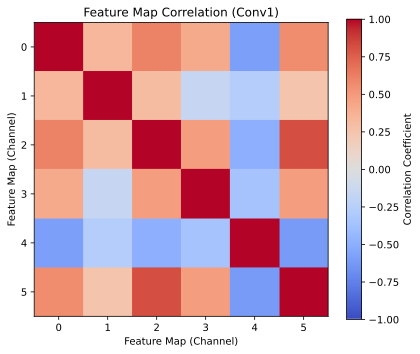

In [19]:
# Visualize correlation of first conv layer (e.g., conv1act)
net, lossfun, optimizer = makeTheNet() 
feature_map_layerwise_correlation(net, test_loader, layer_index=0, layer_name='Conv1')


In [20]:
def function2trainTheModel():
    net, lossfun, optimizer = makeTheNet()
    numepochs = 10

    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    testAcc = torch.zeros(numepochs)

    for epochi in range(numepochs):
        batchLoss = []
        batchAcc = []

        net.train()
        for X, y in train_loader:
            X = X.float()
            y = y.float().view(-1, 1)

            # Forward pass
            yHat, _, _ = net(X)
            loss = lossfun(yHat, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Record loss and accuracy
            batchLoss.append(loss.item())
            predictions = (torch.sigmoid(yHat) > 0.5).float()
            acc = 100 * torch.mean((predictions == y).float())
            batchAcc.append(acc.item())

        trainLoss[epochi] = np.mean(batchLoss)
        trainAcc[epochi] = np.mean(batchAcc)

        # Evaluation
        net.eval()
        with torch.no_grad():
            X, y = next(iter(test_loader))
            X = X.float()
            y = y.float().view(-1, 1)

            yHat, _, _ = net(X)
            loss = lossfun(yHat, y)
            testLoss[epochi] = loss.item()

            predictions = (torch.sigmoid(yHat) > 0.5).float()
            acc = 100 * torch.mean((predictions == y).float())
            testAcc[epochi] = acc.item()

    return trainLoss, testLoss, trainAcc, testAcc, net


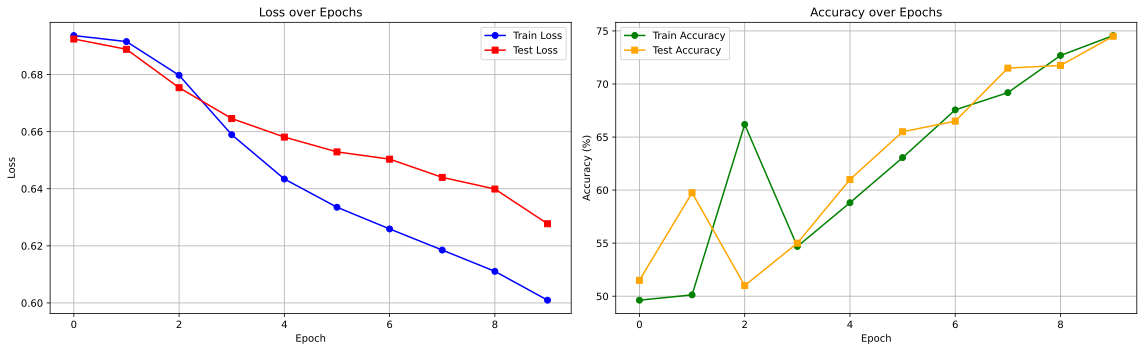

In [22]:
trainLoss, testLoss, trainAcc, testAcc, trainedNet = function2trainTheModel()

import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# ---------- Plot 1: Loss ----------
ax[0].plot(trainLoss, label='Train Loss', color='blue', marker='o')
ax[0].plot(testLoss, label='Test Loss', color='red', marker='s')
ax[0].set_title('Loss over Epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

# ---------- Plot 2: Accuracy ----------
ax[1].plot(trainAcc, label='Train Accuracy', color='green', marker='o')
ax[1].plot(testAcc, label='Test Accuracy', color='orange', marker='s')
ax[1].set_title('Accuracy over Epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend()
ax[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()
